# Simple GAN

我們先從最基礎的GAN來演練，
GAN的全名是生成對抗網路（Generative Adversarial Network），所以簡稱GAN。從名字裡我們不難看出這是一個Generative model,但為什麼要會有對抗呢？要對抗什麼？

事情是這樣的，GAN其實是由兩個神經網路G(generator)和D(Discriminator)所組成，第一篇GAN的paper把G比喻成做假鈔的人，D是警察，G不斷生成仿冒品，D要辦法判斷出哪些是真貨哪些是G做出來的假貨，以下就以產生圖片為例來做說明：

**固定G，訓練D**

*   給D好的圖片和不好的圖片
*   讓看到好的圖片就高分，不好的圖片就給低分

好的圖片從Dataset裡隨機給D，那麼不好的圖片,自然就是G生成的假圖片，要一直讓D覺得G的圖片不夠好，G才會越來越成熟，D當然也要一直訓練，精進自己的辨識技術才能識破G的假貨


**固定D，訓練G**

*   G生成圖片，給D評分
*   G會往調整能讓D給高分的方向調整

G的目標是要製作成功的假貨，所以被D識破之後，就會繼續精進，以能成功騙過D為目標。

整個GAN的運作就會像是這樣

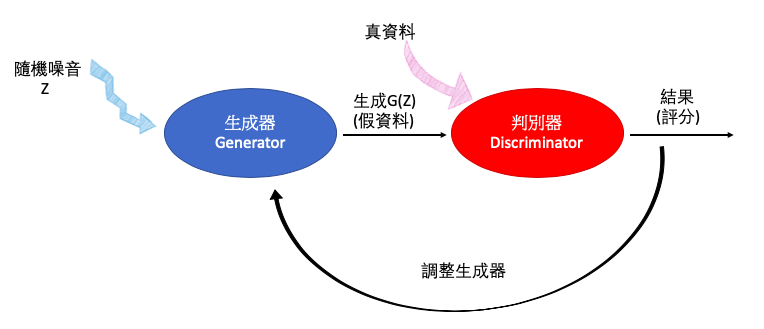

***演算法:***

李宏毅老師每堂課都講的清楚到不可思議，這裡我借用他課堂上的ppt來大略的講解，想知道詳細的話很推薦去上李老師的課
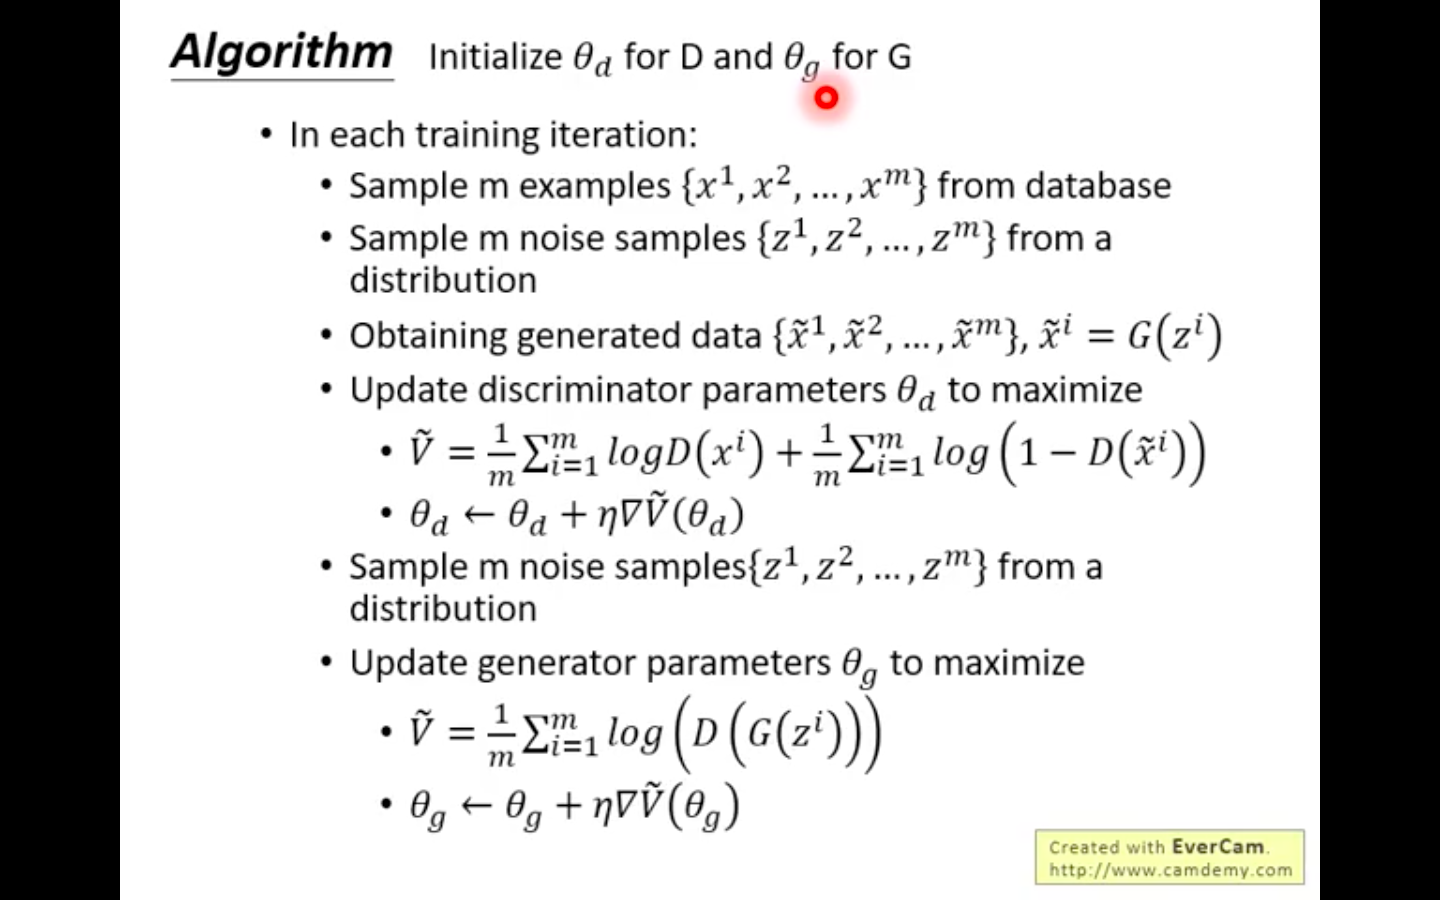

**首先是固定G，訓練D的部分**

1.   先從Database裡隨機抽出m張圖片{x1, x2, ..., xm}
2.   從分佈中生成m個噪音z(也就是隨機向量){z1, z2, ..., zm}
3.   將噪音丟進Generator產生m張假圖片{x̃1, x̃2, ..., x̃m}
4.   更新目標函數(1/m)*Σlog(D(x)) + (1/m)*Σlog(1 - D(G(z)))，
     越大越好，這個式子分成兩項:
     *   (1/m)*Σlog(D(x))這項表示Discriminator判別真圖片的分數，
          所以要越高越好
     *   (1/m)*Σlog(1 - D(G(z)))，表示Discriminator判別假圖片的
         分數，所以才會讓1 - D(G(z)後取log,D(G(z))越小，log值就
         越大
5.   再來就是用調整過的目標函數更新係數

**再來是固定D，訓練G的部分**

1.   生成m個噪音{z1, z2, ..., zm}
2.   從分佈噪音丟到Generator裡面，也就是G(z)
3.   此時的目標函數為maximize --> log(D(G(zi)),也就是說G產生的圖
     片分數越大越好
4.   再來就是用調整過的目標函數更新係數

這裡要注意的是在監督式學習的訓練中，我們用Loss function(損失函數)去產生output,再拿output去對跟真實資料對答案得出差異值，差異值再反向傳播更新參數
GAN則不是用我們自己定義的Loss function去生出差異值，而是用Discriminator去計算差異，更新不是只是參數那麼簡單，而是整個distribution(分佈)






在訓練的過程中就是這樣，訓練完D，再訓練G,再訓練D，再訓練G，一直一直這樣下去，就是像是一個對抗的過程

警察D要把假貨辨識出來，看越多的假貨，辨識能力就越強，仿冒者G就是要在被識破的過程中力求進步，以假亂真。

這就是為什麼會使用Adversarial(對抗)這個字了。

# 實際演練
我以pytorch來實際演練，當然用其他的toolkit也是可以的，Database則是大人小孩都愛的Mnist，裡面有60000張28 x 28的手寫數字，先來簡單說明一下要用到的Library。

torch: pytorch框架，要用pytorch的話起手式就先import他

torch.nn: 可以使用pytorch 支援的神經網路還有活化函數等等

torchvision.datasets:可以直接導入眾多的database，今天就用他來導入Mnist

DataLoader:將資料包裝起來，可以定義如何取樣，一次取樣多少

transforms:對圖片預處理，剪裁，旋轉normalize等等，很方便的tool

save_image:用來儲存生成器生成的圖片

In [ ]:
#import the libaries we need
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

先來架判別器Discriminator

由於是重複做神經網路連接，所以我寫一個block來用,以免看起來落落長，，每一個bolck裡面包含單層 linear neural network跟一個激勵函數(這裡用LeakyRelu)

nn.Linear：設定網路中的全連接層，用來實現網路中節點輸入的線性求和，會將input(x),為線性變換函式：y = xA^T + b。
A就是我們常說的weight，b為bias。

激勵函數(activate function)：若不使用激勵函數，類神經網路即是以線性的方式組合運算，因為隱藏層以及輸出層皆是將上層之結果輸入，並以線性組合計算，使得輸出與輸入只存在著線性關係，然而現實中的問題都是非線性的，因此如果不使用非線性的激勵函數,神經網路訓練便失去意義了


要注意的地方有三點：


1.   最後一層的activate function使用
     sigmoid。

     為了要將參數壓在0到1之間，不然目標函數  log(1 - D(G(z)))，log裡面變負數的話會出錯的。


2.  最後的output要設定為1, 判別器最後只需要輸出一個數字做為評分。


3.  判別器的input就是生成器的output

    前面有講GAN其實就是把生成器吐出來的東西 當成假資料餵給判別器，所以到時候訓練的時候這兩個數字要設成一樣。






介紹一下LeakyReLu和Sigmoid這兩個activate function，首先是LeakyReLu，長這樣

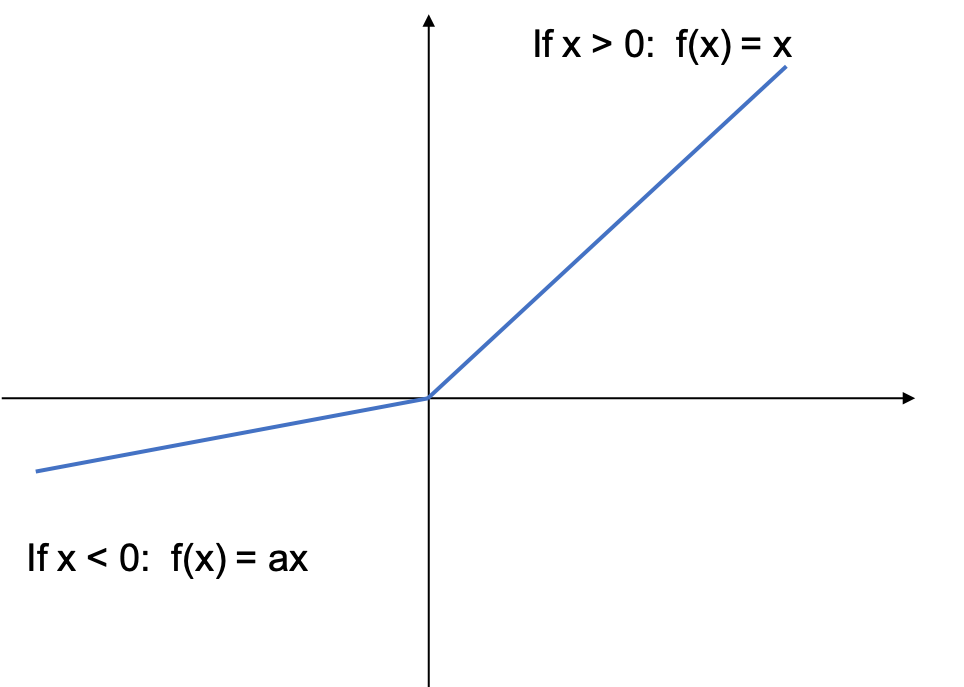

如果輸出的神經網路輸出的結果是正的話，那就一切安好，照抄，如果是負的話，那就會乘上一個非零斜率a,這裡的斜率我們可以自己設定，預設值為0.01

再來是Sigmoid，長這樣

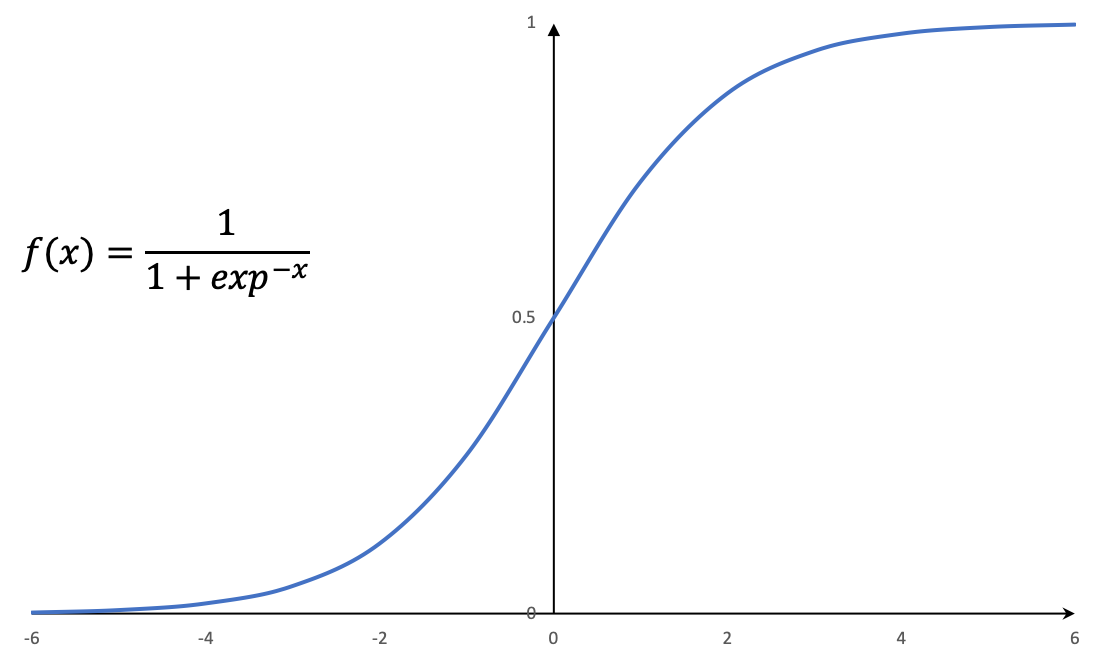

所有的輸出都經過這個函數以後，就會scale到0-1之間。

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,inputSize):
    super(Discriminator, self).__init__()
    self.discr = nn.Sequential(
                   self._block(inputSize, 512),
                   self._block(512, 256),
                   nn.Linear(256,1),#最後的output設1
                   nn.Sigmoid()
                              )
      
  def _block(self, in_features, out_features):
    return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.LeakyReLU(0.02))#LeakyReLu斜率0.02
  def forward(self, x):
    return self.discr(x)

架好後我們input一個數字來看一下我們架好的判別器

In [ ]:
#檢查model
inputsize = 100
print(Discriminator(inputsize))

Discriminator(
  (discr): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
    )
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


接下來就是架判別器Generator,我一樣寫了一個block來代替重複的神經網路組，這裡要注意的有三點


1.   最後一層的activate function使用Tanh
2.   最後的輸出要和真實圖片尺寸一樣
3.   我在block裡面加入Batch Normalization

Batch Normalization很難三言兩語講清楚，想了解的人可以看這篇[ML筆記  Batch Normalization](http://violin-tao.blogspot.com/2018/02/ml-batch-normalization.html)

生成器容易過度學習(過擬合)並且容易有產生不穩定輸出，加入這batch Normalization以增加model穩定性跟準確率。


In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_dim, img_size):
        super(Generator, self).__init__()
        self.gener = nn.Sequential(
                    self._block(input_dim, 256),
                    self._block(256, 512),
                    nn.Linear(512, img_size), 
                    nn.Tanh()

        )
    def _block(self,in_features, out_features):
      return nn.Sequential(nn.Linear(in_features, out_features, bias =False ),
                           nn.BatchNorm1d(out_features),
                           nn.LeakyReLU(0.02))

    def forward(self, x):
        return self.gener(x)

架好後我們一樣input一些數字來檢查一下model

In [ ]:
input_dim = 3
img_size = 28 * 28 * 1
print(Generator(input_dim,img_size))

Generator(
  (gener): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=False)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.02)
    )
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Tanh()
  )
)


我們使用GPU加速，GPU可以做到平行運算以節省大量時間，當然用CPU也是可以做的，只要確定自己活得夠久就行(開玩笑)。

下載完之後用Dataloader包裝，設定batch size(設為32)，也就是一次會要取樣32張圖片，shuffle設為True,也就是會打亂順序後再包裝。最後用迭代器讀取loader檢查，看到輸出的確是為32個1x28x28的圖片。

In [ ]:
#使用GUP加速
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5,], [0.5,])])
batch_size = 32 #batch size設為32
#從dataset下載Mnist
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#用迭代器檢查
images, labels = iter(loader).next()
print(images.shape)

GPU State: cpu


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([32, 1, 28, 28])


打印Mnist的樣子給大家瞧瞧，最後生成器生出來的樣子越像這樣就成功

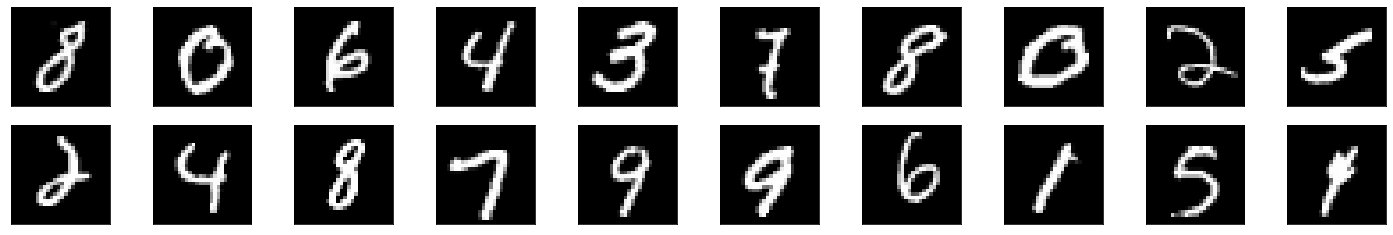

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = iter(loader).next()
images = np.array(images)

fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  plt.imshow(images[i].reshape(28,28),cmap='gray')

接下來就是初始化各項參數,我簡單說明一些我認為需要說明的參數

**loss function:** 

BCELoss,全名Binary Cross Entropy,假設 target為我們要的正確答案、output為我們模型的預測答案，我們便可以透過 BinaryCrossEntropy 計算 target 以及 output 之間的『二元交叉熵』,在二元分類的問題中很常使用。

式子：−(Tlog(O)+(1−T)*log(1−O))


**image_dim:**

Mnist為28x28的灰階圖片，所以尺寸為28x28x1，這是判別器的input尺寸和生成器的輸出尺寸


**opt_disc & opt_gen :**

生成器和判別器的優化器，我們都知道訓練的過程中weight和bias會不斷的更新，目的是為了要取得loss function的最小值，優化器的大致可以理解成調節weight和 bias， 使 loss 盡可能小，這邊使用了Adam作為優化器(一開始不知道要用什麼優化器的話，反手先來一個adam就對了)

In [ ]:
loss = torch.nn.BCELoss()# Initialize loss function
lr_g = 0.0001 # Initializ learning rate of generator
lr_d = 0.0004 # Initializ learning rate of discriminator
input_dim = 64 # input of generator
image_dim = 28 * 28 * 1 
batch_size = 32 
epoches = 50 

#Initialize generator and discriminator
generator = Generator(input_dim, image_dim).to(device)
#Generator最後的output就是discriminator的input
discriminator = Discriminator(image_dim).to(device)
#transform setting

#Initialize optimizer of generator and discriminator
opt_disc = optim.Adam(discriminator.parameters(), lr=lr_d)
opt_gen = optim.Adam(generator.parameters(), lr=lr_g)

最後就是設定訓練函式，我就用註解的方式說明

In [ ]:
def train(discriminator, generator,start_epoches = 0):
  for epoch in range(start_epoches, epoches):
    for i, (data,label) in enumerate(loader):
      ### Train Discriminator

      real = data.view(-1, image_dim).to(device) 
      batch_size = real.shape[0]
      noise = torch.randn(batch_size, input_dim).to(device) 
      fake = generator(noise)
      score_real = discriminator(real).view(-1)
      score_fake = discriminator(fake.detach()).view(-1)
      lossD_real = loss(score_real, torch.ones_like(score_real))
      lossD_fake = loss(score_fake , torch.zeros_like(score_fake))
      lossD = (lossD_real+lossD_fake)/2
      discriminator.zero_grad()
      lossD.backward()
      opt_disc.step()

      ### Train Generator
      output = discriminator(fake).view(-1)
      lossG = loss(output, torch.ones_like(output))
      generator.zero_grad()
      lossG.backward()
      opt_gen.step()

      #初始化fixed noise
      torch.manual_seed(seed = 0)
      fixed_noise = torch.randn(25, input_dim).to(device)
      #每一輪都打印一次loss存圖片
      if i ==0:
        print(f"[{epoch} /{epoches}] [{i}/{len(loader)}] \
          [Dicriminator loss: {lossD}] [Generator loss: {lossG}]")
        
        with torch.no_grad():
          #輸入固定噪音讓生成器生成圖片
          fake_img = generator(fixed_noise).reshape(-1,1,28,28)
          #儲存圖片
          save_image(fake_img.data, f'/content/fake_pic/{epoch+1}_{i}-fake_img.png',nrow=5, normalize=True, scale_each=True)

    state_d = {'model':discriminator.state_dict(), 'optimizer':opt_disc.state_dict(), 'epoch':epoch} #儲存判別器參數
    state_g = {'model':generator.state_dict(), 'optimizer':opt_gen.state_dict(), 'epoch':epoch}# 儲存生成器參數
    torch.save(state_d, "/content/discriminator_M.pth")#儲存判別器
    torch.save(state_g, "/content/generator_M.pth")#儲存生成器


In [ ]:
train(discriminator, generator,start_epoches = 0)

[0 /50] [0/1875]           [Dicriminator loss: 0.6958073377609253] [Generator loss: 0.6751270890235901]
[1 /50] [0/1875]           [Dicriminator loss: 0.0767020583152771] [Generator loss: 3.586378574371338]
[2 /50] [0/1875]           [Dicriminator loss: 0.15676364302635193] [Generator loss: 4.032026290893555]
[3 /50] [0/1875]           [Dicriminator loss: 0.11923003196716309] [Generator loss: 4.1934380531311035]
[4 /50] [0/1875]           [Dicriminator loss: 0.16107365489006042] [Generator loss: 5.886379718780518]
[5 /50] [0/1875]           [Dicriminator loss: 0.15564969182014465] [Generator loss: 5.717442512512207]
[6 /50] [0/1875]           [Dicriminator loss: 0.34002184867858887] [Generator loss: 3.3754444122314453]
[7 /50] [0/1875]           [Dicriminator loss: 0.3425907790660858] [Generator loss: 4.092690467834473]
[8 /50] [0/1875]           [Dicriminator loss: 0.35981103777885437] [Generator loss: 6.935426712036133]
[9 /50] [0/1875]           [Dicriminator loss: 0.309690088033676

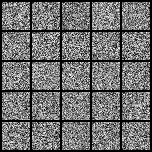

GAN是個非常不穩定的model，訓練起來極其困難，以上的那些參數我也是測了三個晚上，挑出我覺得最好的結果來展示。但是隨著GAN的蓬勃發展，很多研究人員已經有對其穩定性問題進行了大量的研究，目前已有大量的文獻提出了穩定收斂的方法。